In [ ]:
conda env export > environment.yml

In [18]:
import os
import re
import string
import unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [19]:
import inflect
from spellchecker import SpellChecker
import csv

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## import datasets

In [675]:
# import dataset
df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
#target = pd.read_csv('train.csv', usecols=['target'])

In [676]:
print(len(df))
print(len(test_df))

7613
3263


In [677]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print(len(df))
print(len(test_df))

7503
3243


## visualize target data

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

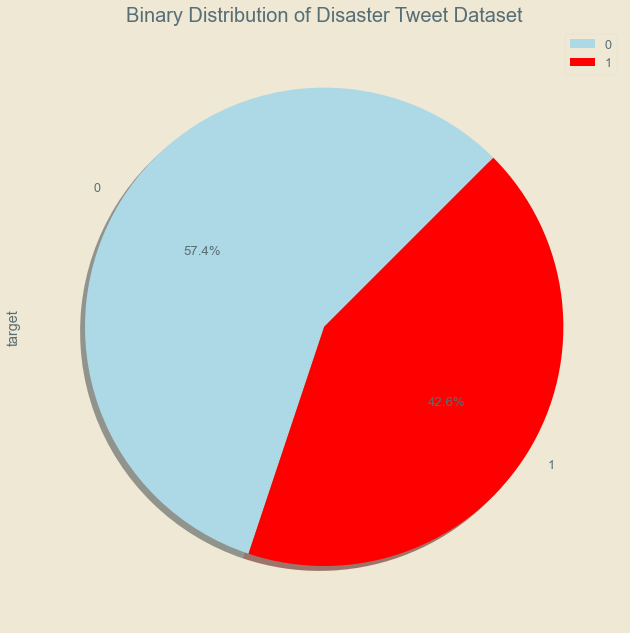

In [194]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

## dictionaries from file for abbreviation/contraction replacement

In [787]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [805]:
location_expansion_dict = csv2dict('location_expansion.csv')
word_expansion_dict = csv2dict('word_expansions.csv')

## denoise

def word_expansion(text, expansion_dict):
        c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text)
        return text
    
def camel_case_split(text):
    if text.startswith('#'):
    #function to expand hashtags containing camel case to words using capital letters as markers for split
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z+]|(?<!\A)(?=[A-Z])[a-z+])'+r'{1,}', r' \1', text)
    else:
        exp_hashtags = text
    return exp_hashtags

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*https?:\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@[^\s]+",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)
    
    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    text = remove_urls(text)
    text = remove_handles(text)
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = remove_non_alpha(text)
    return text      

In [908]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text
    
def camel_case_split(text):
    if text==text.startswith('#'):
    #function to expand hashtags containing camel case to words using capital letters as markers for split
        text = re.sub('#', ' ', text)
        text = re.sub('(.)([A-Z][a-z]+)', r'\1 \2', text)
        exp_hashtags = re.sub('([a-z0-9])([A-Z])', r'\1 \2', text)

        
    else:
        exp_hashtags = text
    return exp_hashtags

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([(?i){ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*https?:\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@[^\s]+",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)
    
    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    text = remove_urls(text)
    
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = remove_non_alpha(text)
    return text      

def word_expansion_from_dict(text, expansion_dict):
    #function to replace words from precomposed dictionary 
    d_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion = f'{expansion_dict[match.group(0)]}'
        return expansion
    for word in text:
        if word.istitle()==True:
            new_text = d_re.sub(replace, text.lower()).capitalize()
            return new_text
        if word.isupper()==True:
            new_text = d_re.sub(replace, text.lower()).upper()
            return new_text
        else:
            new_text = d_re.sub(replace, text)
            return new_text

def word_expansion_from_dict(text, expansion_dict):
    #function to replace words from precomposed dictionary 

    d_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion = f"{expansion_dict[match.group(0)]}"
        return expansion
    text = d_re.sub(replace, text)
    return text
    

def camel_case_split(text):
    if text.startswith('#'):
    #function to expand hashtags containing camel case to words using capital letters as markers for split
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z]|(?<!\A)(?=[A-Z+])[a-z+]{1,})', r' \1', text)
    else:
        exp_hashtags = text
    return exp_hashtags

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([(?i){ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([(?i){ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    text = re.sub(r"\S*https?:\S*",  r"", text)
    return text

def remove_handles(text):
    # function to remove twitter handles from string
    text = re.sub("@[^\s]+",  r" ", text)
    return text

def remove_non_uni(text):
    # function to remove non unicode characters from string
    text= re.sub('[^\u0000-\u007f]', ' ', text)
    return text

def remove_nan_str(text):
    # function to remove 'nan' from string
    text = re.sub('NaN', '', text)
    return text

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    text = re.sub("[^a-zA-Z]",  r" ", text)
    return text
    
    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    text = remove_urls(text)
    text = remove_handles(text)
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = remove_non_alpha(text)
    return text      

## tokenize 

def lemmatize_text_verbs(text):
    #function to tokenize and lemmatize text, and split text into tokens
    lemmatizer = WordNetLemmatizer()
    if text==text.title():
        word = lemmatizer.lemmatize(text, 'v').capitalize()
    if text==text.isupper():
        word = lemmatizer.lemmatize(text, 'v').upper()
    else:
        word = lemmatizer.lemmatize(text, 'v')
    return word

def lemmatize_text_nouns(text):
    #function to tokenize and lemmatize text, and split text into tokens
    lemmatizer = WordNetLemmatizer()
    if text==text.title():
        word = lemmatizer.lemmatize(text, 'n').capitalize()
    if text==text.isupper():
        word = lemmatizer.lemmatize(text, 'n').upper()
    else:
        word = lemmatizer.lemmatize(text, 'n')
    return word

In [909]:
def lemmatize_text(text):
    #function to tokenize and lemmatize text, removing twitter handles and reducing length of words ex. loool = lol
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, 'v') for w in text.split(' ')]
    return tokens


def replace_numbers(tokens):
    # function to replace digits in string with numbers spelled out as words ex 11 = eleven
    dig2word = inflect.engine()
    new_tokens = []
    for word in tokens:
        word = re.sub('(?<=\d),(?=\d)', '', word)
        if word.isdigit():
            new_word = dig2word.number_to_words(int(word))
            new_tokens.append(str(new_word))
        else:
            new_tokens.append(word)
    return new_tokens

def remove_non_ascii(tokens):
    # function to remove non unicode characters from tokenized text
    new_tokens = []
    for word in tokens:
        new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_tokens.append(new_token)
    return new_tokens

def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens

def norm_text(tokens):
    # function to normalize text by replacing digits with words and removing stopwords performed on tokenized text
    words = replace_numbers(tokens)
    #new_words = remove_stopwords(words)
    return words

## tweet text process

In [910]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        text = remove_handles(text)
        camel_text = camel_case_split(text)
        exp_loc_tweet = word_expansion_from_dict(camel_text, expansion_dict=location_expansion_dict)
        exp_text = word_expansion_from_dict(exp_loc_tweet, expansion_dict=word_expansion_dict)
        return exp_text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join(x for x in norm_text(lem_text) if len(x) > 1)
        return text

    
    new_df = [process_text(x) for x in df]

    return new_df 

## keyword text process

In [911]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [912]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_text(text):
        camel_text = camel_case_split(text) 
        #loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(camel_text, location_expansion_dict)
        return exp_text
        
    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join([x for x in norm_text(lem_text)])
        return text
    
    new_df = [process_text(x) for x in df]
    return new_df 

## create column containing combined column text & tokens columns

In [913]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweets.apply(lambda row: row.split())
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

# create new dataframe applying above processes

In [914]:
df['tweets'] = process_tweet(df.text)
test_df['tweets'] = process_tweet(test_df.text)
df['clean_keyword'] = process_keyword(df.keyword.astype(str))
test_df['clean_keyword'] = process_keyword(test_df.keyword.astype(str))
df['clean_location'] = process_location(df.location.astype(str))
test_df['clean_location'] = process_location(test_df.location.astype(str))

train_df = combine_columns(df)
test_df2 = combine_columns(test_df)

In [828]:
print(test_df.text[388])
print(test_df.text[391])
print(test_df.text[392])

U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/FLcQQeZnVW via @Change
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/FaXDzI90dY via @Change
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/n6VeOjW3S8 via @Change


In [915]:
test_df.tweets[100:150]

id
342                he be probably annihilate need his DD
343    GMCR no longe rGreen mountain now Red Mountain...
350    Please sign amp RETWEET to save SaltRiverWildH...
351    Allied Plans for the Annihilation of the Germa...
357    Please share and sign this petition to save wi...
359    YOU National Park Services Tonto National Fore...
362               NEW Are souls punish with annihilation
366    Latest Updates on the Salt River Wild Horse Ro...
367    YOU National Park Services Tonto National Fore...
369    YOU National Park Services Tonto National Fore...
373    Out of the Silent Planet in print and Annihila...
374    RETWEET SIGN URGENT Stop the Annihilation of t...
376                     do only get the ice annihilation
377    YOU National Park Services Tonto National Fore...
378    YOU National Park Services Tonto National Fore...
379    under Sonia Gandhi be like Pakistan Every defe...
382    YOU National Park Services Tonto National Fore...
385    YOU National Park Ser

In [906]:
test_df[100:150]

,keyword,location,text,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
id,,,,,,,,,
342,annihilated,"Salem, MA",@AlbertBreer he was probably annihilated neede...,Breer he be probably annihilate need his DD,annihilated,salem massachusetts,Breer he be probably annihilate need his DD sa...,"[Breer, he, be, probably, annihilate, need, hi...","[Breer, he, be, probably, annihilate, need, hi..."
343,annihilated,"Chicago, Illinois",$GMCR no longe rGreen mountain now Red Mountai...,GMCR no longe be Green mountain now Red Mounta...,annihilated,chicago illinois,GMCR no longe be Green mountain now Red Mounta...,"[GMCR, no, longe, be, Green, mountain, now, Re...","[GMCR, no, longe, be, Green, mountain, now, Re..."
350,annihilation,NaN,Please sign &amp; RT to save #SaltRiverWildHor...,Please sign amp RETWEET to save Salt River Wil...,annihilation,,Please sign amp RETWEET to save Salt River Wil...,"[Please, sign, amp, RETWEET, to, save, Salt, R...","[Please, sign, amp, RETWEET, to, save, Salt, R..."
351,annihilation,NaN,Allied Plans for the Annihilation of the Germa...,Allied Plans for the Annihilation of the Germa...,annihilation,,Allied Plans for the Annihilation of the Germa...,"[Allied, Plans, for, the, Annihilation, of, th...","[Allied, Plans, for, the, Annihilation, of, th..."
357,annihilation,"Yeezy Taught Me , NV",Please share and sign this petition to save wi...,Please share and sign this petition to save wi...,annihilation,yeezy taught me nevada,Please share and sign this petition to save wi...,"[Please, share, and, sign, this, petition, to,...","[Please, share, and, sign, this, petition, to,..."
359,annihilation,Colorado,U.S National Park Services Tonto National Fore...,YOU National Park Services Tonto National Fore...,annihilation,colorado,YOU National Park Services Tonto National Fore...,"[YOU, National, Park, Services, Tonto, Nationa...","[YOU, National, Park, Services, Tonto, Nationa..."
362,annihilation,United States,NEW! Are souls punished with annihilation? htt...,NEW Are souls punish with annihilation NV Vy FCQ,annihilation,united states,NEW Are souls punish with annihilation NV Vy F...,"[NEW, Are, souls, punish, with, annihilation, ...","[NEW, Are, souls, punish, with, annihilation, ..."
366,annihilation,High Desert,***Latest Updates on the Salt River Wild Horse...,Latest Updates on the Salt River Wild Horse Ro...,annihilation,high desert,Latest Updates on the Salt River Wild Horse Ro...,"[Latest, Updates, on, the, Salt, River, Wild, ...","[Latest, Updates, on, the, Salt, River, Wild, ..."
367,annihilation,"Plovdiv, Bulgaria",U.S National Park Services Tonto National Fore...,YOU National Park Services Tonto National Fore...,annihilation,plovdiv bulgaria,YOU National Park Services Tonto National Fore...,"[YOU, National, Park, Services, Tonto, Nationa...","[YOU, National, Park, Services, Tonto, Nationa..."


In [ ]:
test_df2.to_csv('test_update.csv')
train_df.to_csv('train_update.csv')

In [ ]:
test_df = pd.read_csv('test_update.csv')
train_df = pd.read_csv('train_update.csv')

In [82]:
from nltk.corpus import names
for t in df.tweet_tokens: 
    if t in names:
        t = re.sub(t, )

In [ ]:
for token in text:
    if token in names:
        text = re.sub(token, ' ',   )

In [95]:
corps = []
for token in df.tweets:
    s = token.split()
    corps.extend(s) 

In [92]:
df.loc[df.text.str.contains('akxbskdn')]

,keyword,location,text,target,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
id,,,,,,,,,,
4953,exploded,elizabeth king,oh yeah my ipod almost exploded last night i w...,1,oh yeah my ipod almost explode last night be u...,exploded,elizabeth king,oh yeah ipod almost explode last night use cha...,"[oh, yeah, ipod, almost, explode, last, night,...","[oh, yeah, ipod, almost, explode, last, night,..."


In [94]:
corps = np.unique(corps)
corps[300:600]

array(['#ContentMarketing', '#Conversations', '#CopaLibertadores',
       '#CountyNews', '#Cowboys:', '#Crash', '#Crush', '#Cubs',
       '#CubsTalk', '#Cyclone', '#Cyprus:', '#DC', '#DE', '#DFIR', '#DNA',
       '#DONZILLA...', '#DOOMSDAY', '#DU19', '#DUBAI', '#DVD', '#DW',
       '#Dance', '#Death', '#Deaths', '#DebateQuestionsWeWantToHear',
       '#DecisionsOnDecisions', '#Defendant', '#Deluge', '#Demolition',
       '#Denver', '#Dependency', '#Desolation', '#DestinationIMPACT',
       '#Destroy', '#Directioners', '#DisabledVeterans', '#Disaster',
       '#Disaster.', '#Disney', '#Diversification', '#Diyala', '#DnB',
       '#DoubleCups', '#DoubleGhats', '#DroughtMonitor:', '#Drum', '#Dua',
       '#Dublin', '#Dubstep', '#Dumuzid', '#Durant', '#Dutton',
       '#Dynamix', '#EBOLA', '#EDM', '#EDWING', '#EMERGENCY', '#EMS',
       '#EMSNe\x89Û_', '#ENGvAUS', '#ENVIRONMENT', '#ES', '#EY', '#Earth',
       '#EarthQuake', '#EarthTwerk', '#Earthquake', '#EarthquakeNews',
       '#Ebola',

In [ ]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

In [ ]:
r

In [ ]:
from spellchecker import SpellChecker
misspelled_list = []
misspelled_suggestions = []
ms_others = []

spell = SpellChecker()

for str in corpus:
    misspelled = spell.unknown(str)
    misspelled_list.append(str)
    misspelled_suggestions.append(spell.correction(str))
    ms_others.append(spell.candidates(str))

In [ ]:
misspelled_suggestions

In [124]:
from collections import Counter
word_dict = Counter(train_df.tweet_tokens.sum())
word_dict

Counter({'deeds': 2,
         'reason': 31,
         'earthquake': 50,
         'may': 88,
         'allah': 9,
         'forgive': 6,
         'us': 162,
         'forest': 66,
         'fire': 363,
         'near': 58,
         'la': 14,
         'ronge': 1,
         'sask': 1,
         'canada': 14,
         'residents': 8,
         'ask': 31,
         'shelter': 7,
         'place': 35,
         'notify': 1,
         'officer': 38,
         'evacuation': 50,
         'order': 41,
         'expect': 33,
         'people': 217,
         'receive': 4,
         'wildfires': 10,
         'california': 137,
         'get': 434,
         'send': 52,
         'photo': 42,
         'ruby': 1,
         'alaska': 10,
         'smoke': 54,
         'pour': 4,
         'school': 70,
         'rocky': 12,
         'update': 57,
         'highway': 19,
         'close': 39,
         'directions': 1,
         'due': 31,
         'lake': 15,
         'county': 40,
         'cafire': 2,
         'fl

In [125]:
len(word_dict)

12181

In [88]:
print(max(word_dict))

zz


In [ ]:
df

In [ ]:
df